# Fixed Coupon Bond

The goal of the project is to compute the market value of a portfolio of fixed coupon bonds taking into account the issuer credit risk. The input parameters are:

* the par rate of a set of Overnight Index Swaps (i.e. their market quotations);
* a set of survival probabilities of the issuer and the recovery rate;
* the static data of the pool of bonds (nominal, start date, end date, coupons, payment frequency).

### Notes and hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for evaluation of risky flows.

Remember to reuse the code we developed during the lessons in `finmarkets.py` as much as possible, instead of trying to rewrite everything from scratch!

When it is impossible develop your own classes.

In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/Projects')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta

today = date(2019, 10, 31)

ois_quotes = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/ois_quotes.csv")
surv_prob = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/survival_probabilities_proj4.csv")
bond_pool = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/bonds_to_price_proj4.csv")

First of all we need to determine the discount curve from the market quotes of a set of OIS using the bootstrap technique. Also, before defining the discount curve I have checked the minimization results).

In [ ]:
from finmarkets import OvernightIndexSwap

pillar_dates = [today]
swaps = []

for q in range(len(ois_quotes)):
  swap = OvernightIndexSwap(1e6, today, 
                            ois_quotes.loc[q, 'quote']*0.01,
                            ois_quotes.loc[q, 'months'])
    
  swaps.append(swap)
  pillar_dates.append(swap.payment_dates[-1])

In [ ]:
from finmarkets import DiscountCurve

def objective_function(x):
    curve = DiscountCurve(pillar_dates, x)
    sum_sq = 0.0
    for swap in swaps:
        sum_sq += swap.npv(curve) ** 2
        
    return sum_sq 

In [ ]:
from scipy.optimize import minimize

x0 = [1.0 for i in range(len(pillar_dates))]
bounds = [(0.01, 10.0) for i in range(len(pillar_dates))]
bounds[0] = (1, 1)

result = minimize(objective_function, x0, bounds=bounds)

[1.         1.00040399 1.00082112 1.0012397  1.00162942 1.00204562
 1.00244425 1.00285344 1.00324509 1.00364369 1.00403373 1.00440408
 1.00467298 1.00678563 1.0089525  1.01024583 1.01070549 1.009931
 1.00775586 1.00433842 0.9997303  0.99391153 0.98726976 0.98007543
 0.97221833 0.94694648 0.91134835 0.88803027 0.8755708  0.86625742
 0.85942386 0.85104148]
114310966741.92604
0.0007412036724214782


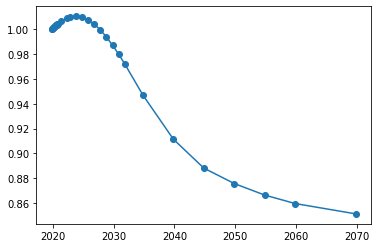

In [ ]:
print (result.x)
print (objective_function(x0))
print (objective_function(result.x))

from matplotlib import pyplot as plt
plt.plot(pillar_dates, result.x, marker='o')
plt.show()

In [ ]:
dc = DiscountCurve(pillar_dates, result.x)

Then we need to determine the credit curve from the non-default probabilities given in input.

In [ ]:
from finmarkets import CreditCurve

dates = [today + relativedelta(years=i) for i in surv_prob['years']]
cc = CreditCurve(dates, surv_prob['ndp'])

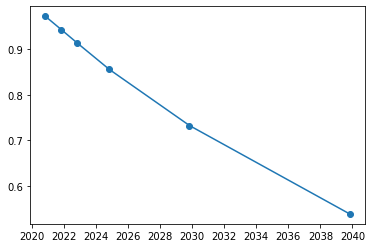

In [ ]:
plt.plot(dates, surv_prob['ndp'], marker='o')
plt.show()

In the end a new class to price the bonds has been developed. The same class is used later to compute the portfolio value.

In [ ]:
from math import exp
from finmarkets import generate_dates

class FloatingBond:
  def __init__(self, notional, start_date, maturity_months, 
               coupon, tenor, recovery):

    self.notional = notional
    self.payment_dates = generate_dates(start_date, maturity_months, tenor)
    self.coupon = coupon
    self.recovery = recovery
                   
  def pricing(self, pricing_date, dc, cc):            
    price = 0
    for d in self.payment_dates:
      if d > pricing_date:
        price += self.coupon * self.notional * dc.df(d) * cc.ndp(d)
    if d > pricing_date:
      price += self.notional * dc.df(d) * cc.ndp(d)
        
    while pricing_date + relativedelta(days=1) <= self.payment_dates[-1]:
      price += self.recovery * self.notional * dc.df(pricing_date) * (cc.ndp(pricing_date) - cc.ndp(pricing_date+relativedelta(days=1)))
      pricing_date += relativedelta(days=1)

    return price

In [ ]:
import datetime 
ptf_price = 0.0

for i, b in bond_pool.iterrows():
  ptf = FloatingBond(b['nominal'], pd.to_datetime(b['start_date']).date(),
                     b['maturity'], b['coupon'], 
                     b['tenor'], b['recovery'])

  ptf_price += ptf.pricing(today, dc, cc)

print ("The market value of the portfolio is {:.2f}".format(ptf_price))

The market value of the portfolio is 32073577.27
